In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [11]:
DATASET_DIR = r"C:\Users\ADMIN\Visual Studio Code Projects\Python\XLAS_Project\dataset_new"

TRAIN_DIR = DATASET_DIR + "/train"
VAL_DIR   = DATASET_DIR + "/valid"
TEST_DIR  = DATASET_DIR + "/test"

In [12]:
# Generator cho Little VGG (48x48 GRAYSCALE)
vgg_lite_datagen = ImageDataGenerator(rescale=1./255)

train_gen_vgglite = vgg_lite_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48,48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

val_gen_vgglite = vgg_lite_datagen.flow_from_directory(
    directory=VAL_DIR,
    target_size=(48,48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

test_gen_vgglite = vgg_lite_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(48,48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 21529 images belonging to 7 classes.
Found 7177 images belonging to 7 classes.
Found 7181 images belonging to 7 classes.


In [13]:
# Generator cho VGG16 
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

In [14]:
# VGG16
vgg16_datagen = ImageDataGenerator(rescale=1./255)

train_gen_vgg16 = vgg16_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48,48),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

val_gen_vgg16 = vgg16_datagen.flow_from_directory(
    directory=VAL_DIR,
    target_size=(48,48),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_gen_vgg16 = vgg16_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(48,48),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 21529 images belonging to 7 classes.
Found 7177 images belonging to 7 classes.
Found 7181 images belonging to 7 classes.


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

train_dir = r"C:\Users\ADMIN\Visual Studio Code Projects\Jupyter Notebook\fer-2013\train" 
test_dir = r"C:\Users\ADMIN\Visual Studio Code Projects\Jupyter Notebook\fer-2013\test" 

eval_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen_resnet = eval_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=False
)

val_gen_resnet = eval_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_gen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
def evaluate_model(model, train_gen, val_gen, test_gen, model_name):
    print(f"\n===== {model_name} =====")

    # ===== 1. Accuracy tổng =====
    train_loss, train_acc = model.evaluate(train_gen, verbose=0)
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)

    print(f"Train Acc = {train_acc*100:.2f}%")
    print(f"Val Acc   = {val_acc*100:.2f}%")
    print(f"Test Acc  = {test_acc*100:.2f}%")

    # ===== 2. Prediction =====
    test_gen.reset()
    pred_probs = model.predict(test_gen, verbose=0)
    pred_classes = np.argmax(pred_probs, axis=1)
    true_classes = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    # ===== 3. Classification Report =====
    print("\nClassification Report:")
    report = classification_report(
        true_classes,
        pred_classes,
        target_names=class_labels,
        output_dict=True
    )
    print(classification_report(
        true_classes,
        pred_classes,
        target_names=class_labels
    ))

    # ===== 4. Confusion Matrix =====
    cm = confusion_matrix(true_classes, pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=class_labels,
        yticklabels=class_labels,
        cmap="Blues"
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # =========================================================
    # 🔹 5. BAR CHART: Precision / Recall / F1-score theo class
    # =========================================================
    df_report = pd.DataFrame(report).transpose()
    df_classes = df_report.loc[class_labels, ["precision", "recall", "f1-score"]]

    df_classes.plot(
        kind="bar",
        figsize=(12,6)
    )
    plt.title(f"Classification Metrics per Class - {model_name}")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.legend(loc="lower right")
    plt.show()

    # =========================================================
    # 🔹 6. BAR CHART: Accuracy theo từng class
    # =========================================================
    class_accuracy = {}

    for i, class_name in enumerate(class_labels):
        idx = np.where(true_classes == i)
        acc = accuracy_score(true_classes[idx], pred_classes[idx])
        class_accuracy[class_name] = acc

    plt.figure(figsize=(10,5))
    plt.bar(class_accuracy.keys(), class_accuracy.values())
    plt.title(f"Per-Class Accuracy - {model_name}")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    for i, v in enumerate(class_accuracy.values()):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.grid(axis="y")
    plt.show()

    return test_acc

In [17]:
def load_legacy_model(path):
    model = load_model(path, compile=False)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

c:\Users\ADMIN\Visual Studio Code Projects\Python\XLAS_Project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



===== Little VGG =====
Train Acc = 77.77%
Val Acc   = 66.52%
Test Acc  = 67.76%

Classification Report:
              precision    recall  f1-score   support

       angry       0.63      0.57      0.60       991
     disgust       0.80      0.41      0.54       110
        fear       0.57      0.44      0.50      1025
       happy       0.88      0.86      0.87      1798
     neutral       0.58      0.73      0.65      1240
         sad       0.55      0.58      0.57      1216
    surprise       0.76      0.79      0.78       801

    accuracy                           0.68      7181
   macro avg       0.68      0.63      0.64      7181
weighted avg       0.68      0.68      0.68      7181



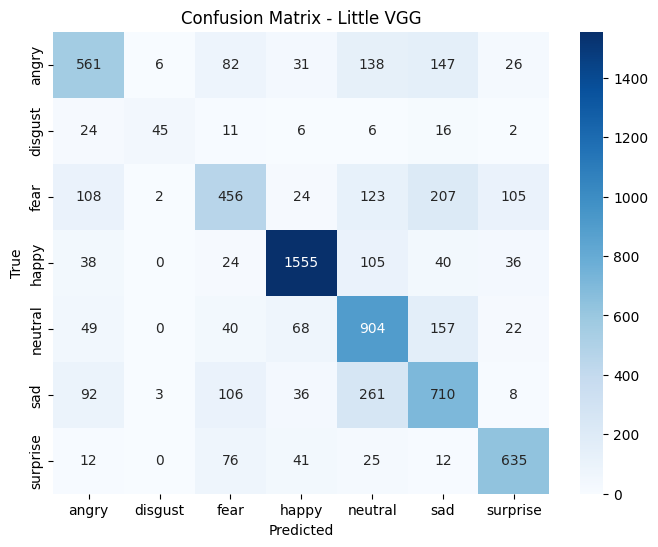

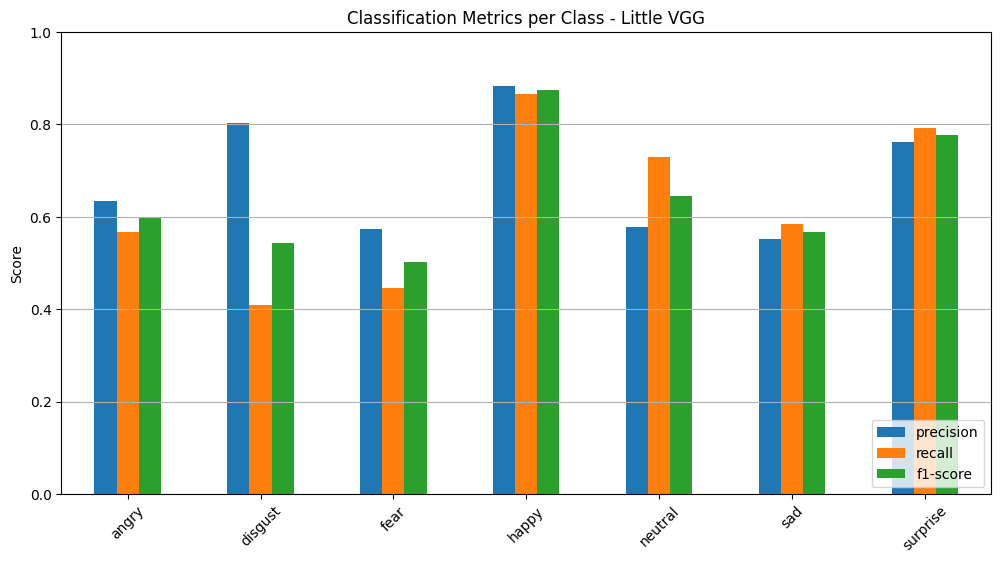

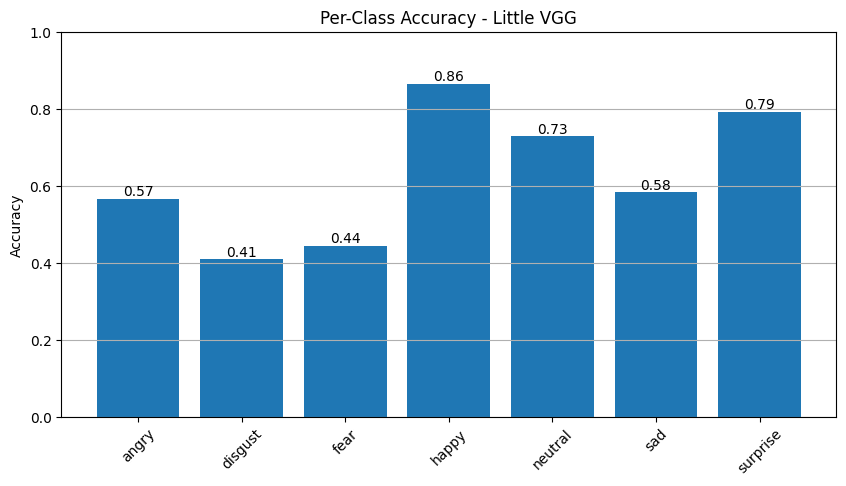


===== VGG16 Optimized =====
Train Acc = 75.16%
Val Acc   = 61.81%
Test Acc  = 60.91%

Classification Report:
              precision    recall  f1-score   support

       angry       0.50      0.52      0.51       991
     disgust       0.78      0.16      0.27       110
        fear       0.48      0.44      0.46      1025
       happy       0.79      0.83      0.81      1798
     neutral       0.54      0.59      0.56      1240
         sad       0.50      0.47      0.49      1216
    surprise       0.74      0.75      0.74       801

    accuracy                           0.61      7181
   macro avg       0.62      0.54      0.55      7181
weighted avg       0.61      0.61      0.60      7181



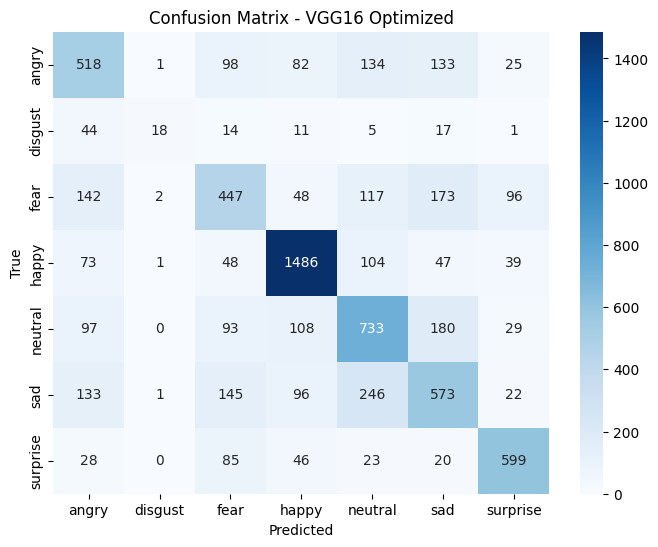

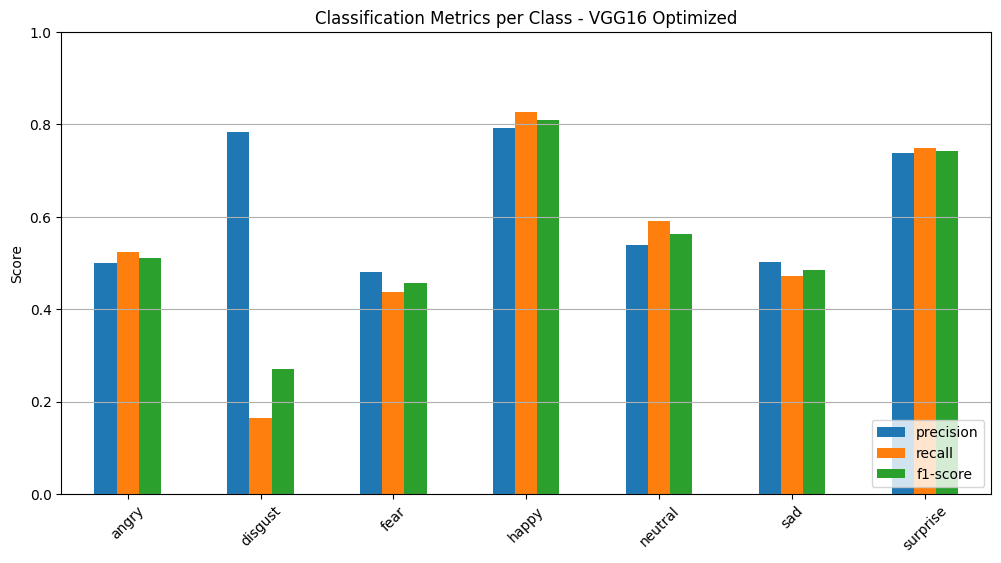

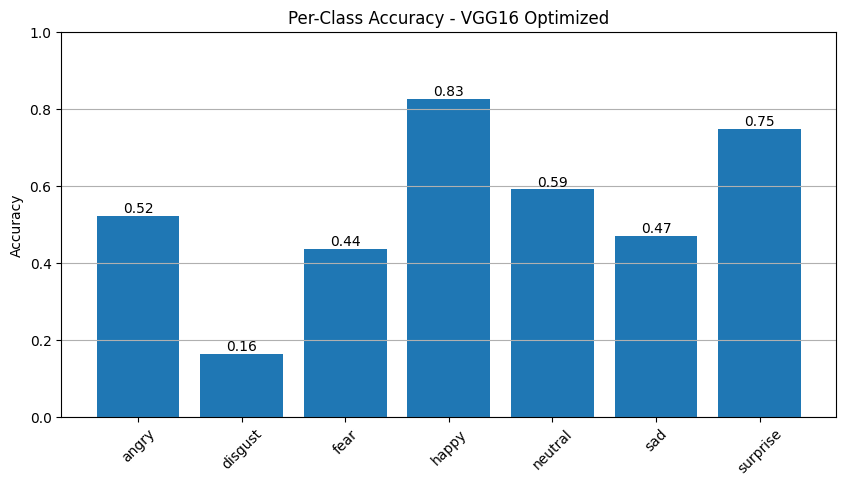


===== ResNet50 Fine-tuned =====
Train Acc = 92.54%
Val Acc   = 64.00%
Test Acc  = 64.84%

Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.52      0.57       958
     disgust       0.61      0.46      0.53       111
        fear       0.50      0.49      0.50      1024
       happy       0.83      0.84      0.83      1774
     neutral       0.56      0.67      0.61      1233
         sad       0.54      0.50      0.52      1247
    surprise       0.77      0.79      0.78       831

    accuracy                           0.65      7178
   macro avg       0.63      0.61      0.62      7178
weighted avg       0.65      0.65      0.65      7178



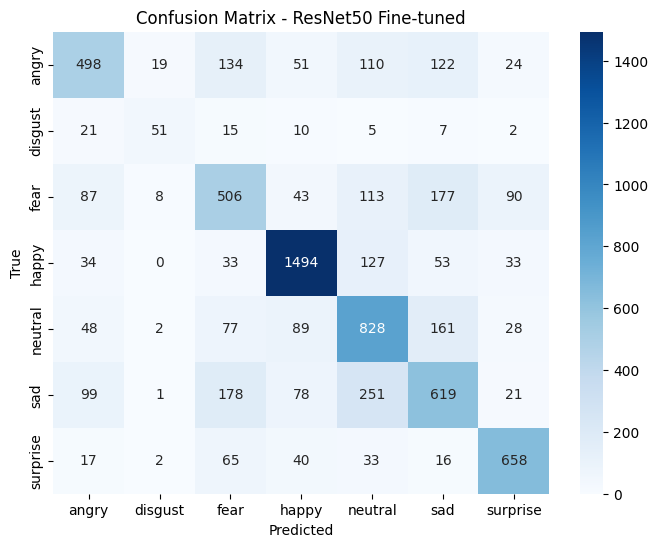

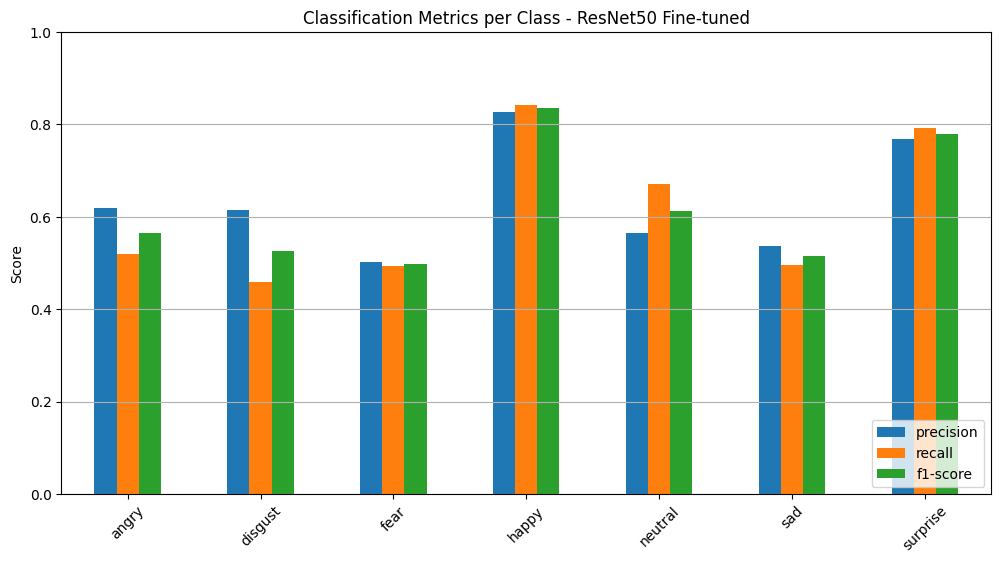

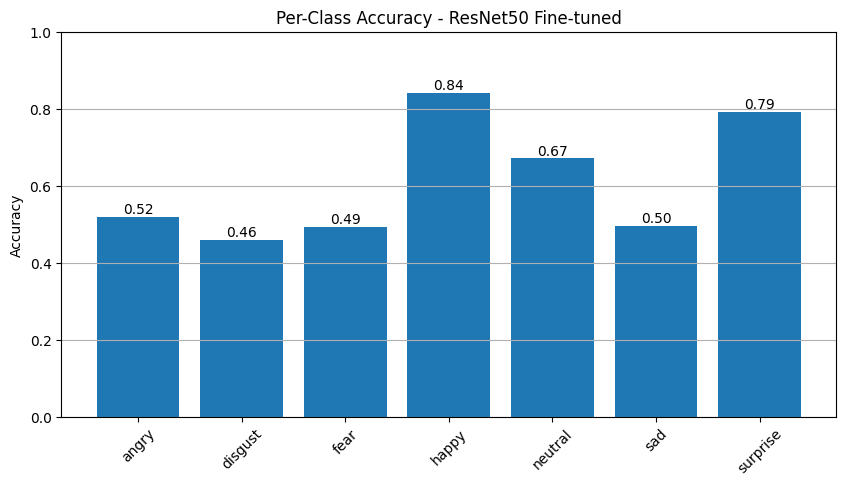

In [18]:
model_vgglite = load_legacy_model(r"C:\Users\ADMIN\Visual Studio Code Projects\Python\XLAS_Project\models\Emotion_little_vgg.h5")

acc_vgglite = evaluate_model(
    model_vgglite,
    train_gen_vgglite,
    val_gen_vgglite,
    test_gen_vgglite,
    "Little VGG"
)

model_vgg16 = load_legacy_model(r"C:\Users\ADMIN\Visual Studio Code Projects\Python\XLAS_Project\models\Emotion_VGG16_Optimized.h5")

acc_vgg16 = evaluate_model(
    model_vgg16,
    train_gen_vgg16,
    val_gen_vgg16,
    test_gen_vgg16,
    "VGG16 Optimized"
)

model_resnet = load_model(r"C:\Users\ADMIN\Visual Studio Code Projects\Python\XLAS_Project\models\resnet50_fer_finetuned.keras")

acc_resnet = evaluate_model(
    model_resnet,
    train_gen_resnet,
    val_gen_resnet,
    test_gen_resnet,
    "ResNet50 Fine-tuned"
)

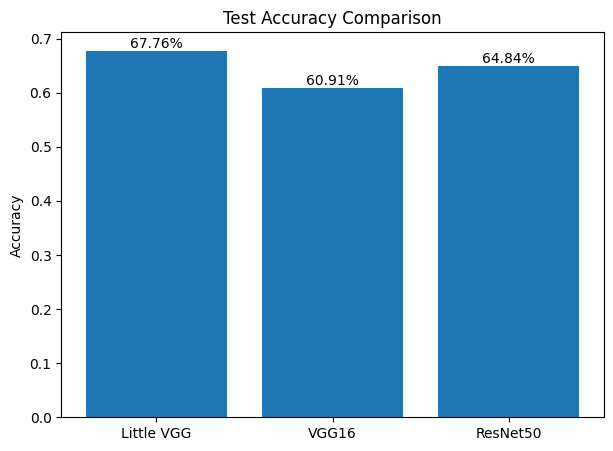

In [19]:
models = ["Little VGG", "VGG16", "ResNet50"]
accs = [acc_vgglite, acc_vgg16, acc_resnet]

plt.figure(figsize=(7,5))
plt.bar(models, accs)
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")

for i, v in enumerate(accs):
    plt.text(i, v, f"{v*100:.2f}%", ha="center", va="bottom")

plt.show()